# Relatório do projeto - Mineração de Dados

## Matheus Fernandes
## Pedro Faustini

## 1. Introdução

Este trabalho estuda técnicas de mineração de dados para classificar áudio. Em específico, o universo a ser classificado consiste em dez caracteres: 6, 7, a, b, c, d, h, m, n, x. Cada arquivo de áudio, chamado de _captcha_, contém 4 caracteres, podendo haver caracteres repetidos ou não. O objetivo é identificar quais caracteres estão presentes nos _captchas_. A classificação de um _captcha_ é considerada sucesso quando **todos** os seus quatro caracteres são corretamente identificados. Caso haja um ou mais caracteres erroneamente classificados em um _captcha_, a classificação é considerada errada para aquele _captcha_.

### Ferramentas necessárias para a reprodução:

Para este trabalho foram utilizadas as ferramentas mencionadas abaixo. É importante prestar atenção nas versões das mesmas, quando indicadas.

#### Programas e ambientes
- FFMPEG
- Anaconda (Python>=3.5) 
- Linux

#### Bibliotecas python
-  numpy>=1.13.3
-  pandas>=0.20.3
-  scikit-learn>=0.19.1
-  scipy==1.1.0 
-  librosa>=0.6.1
-  matplotlib>=1.5.3
-  ipython>=6.2.1
-  Sox (`conda install -c conda-forge sox`)

#### Pastas
- É assumido que no diretório em que se encontra este documento haja uma pasta chamada *fase\_1*. Dentro desta pasta deve haver duas pastas: *base\_treinamento\_I* e *base\_validacao\_I*, cada uma uma com os captchas de áudio.


Numpy e Pandas são bibliotecas criadas para manipular vetores de uma forma mais otimizada e rica em informação em relação à classe _list_ da biblioteca padrão do Python. Scikit-learn é uma biblioteca que implementa diversos algoritmos de mineração de dados, bem como técnicas de transformação e pré-processamento. Scipy é uma biblioteca usada para computação científica. Matplotlib fornece funções para plotar imagens e gráficos. Por fim, librosa é uma biblioteca para manipulação de áudio. 

Além das bibliotecas citadas, já fornecemos junto com os arquivos a biblioteca `pysndfx`, que nada mais é do que um *wrapper* para o Sox. A biblioteca está disponível no [Github](https://github.com/carlthome/python-audio-effects).

## 2. Análise exploratória

A primeira tarefa é criar a estrutura de pastas necessárias para segmentar os _captchas_. Como cada _captcha_ contém quatro caracteres, a ideia é gerar quatro arquivos `.wav`, um para cada caractere.

In [1]:
from IPython.display import display

In [2]:
from main import create_folder_structure
#create_folder_structure()

### 2.1 Segmentação

A segmentação segue os passos:

- O áudio é normalizado (tornando o maior pico = 1) e os silêncios ao início e ao fim são removidos;
- Um _limiter_ é aplicado, com o parâmetro de 20dB. Isso significa que qualquer sinal com intensidade maior que este limite são diminuídos até 20dB. Isso é feito para tentar reduzir a diferença entre picos mais altos e mais baixos, pois nem todas as letras são gravadas com a mesma intensidade;
- Frequências acima de 2500Hz e abaixo de 100Hz são descartadas, pois são frequências com pouca informação vocal;
- Então, um equalizador é aplicado na faixa de 300Hz, intensificando essas frequências por 15dB. Na prática, isso causa um *boost* nas regiões onde há grande informação vocal, potencialmente até distorcendo-as, e deixando a diferença entre voz e fundo muito mais clara;
- Samples com intensidade menor que 0.5 são zerados, em uma tentativa de remover ruído de gravação. Idealmente, regiões silenciosas (sem voz) seriam zeradas;
- A função `find_peaks`, da biblioteca `scipy.signal` é usada para encontrar os picos do áudio. Essa função retorna todos os máximos e mínimos locais de um sinal. Mesmo passando parâmetros de altura mínima (de forma a apenas encontrar máximos) e distância mínima de 1s entre picos, por vezes a função encontra mais do que 4 picos, chamados daqui em diante de pontos;
- A intenção é que cada ponto represente um caractere. São escolhidos os pares de pontos mais próximos um do outro, e ambos são removidos e substituídos pela sua média. Isso é feito até que restem apenas 4 pontos. Teoricamente, ao fazer isso estamos pegando os caracteres com mais de um pico e colapsando suas posições até restar apenas um ponto, próximo ao seu centro;
- A partir de cada ponto encontrado, é extraída do áudio original uma região de 1s para cada lado, totalizando no máximo 2s de áudio. O ruído de fundo (silêncio) de cada lado e removido, isolando apenas a fala, e, como essa operação normalmente remove o começo e final do caractere, 0.25s são adicionados de volta de cada lado;
- Os áudios encontrados são exportados, assumindo que foram encontrados na ordem em que estão presentes no nome do arquivo.


Na imagem abaixo, desenhamos as ondas de um exemplo da base de treinamento.

A onda verde representa o áudio original; a onda azul mostra o áudio após feito o processamento. Pode-se notar que os picos estão bem mais visíveis, e as regiões de ruído de fundo tornaram-se silêncio; dessa forma, temos um áudio próximo de "binarizado", onde 1 é fala, e 0 é silêncio.

Os riscos em vermelho são os quatro pontos encontrados.

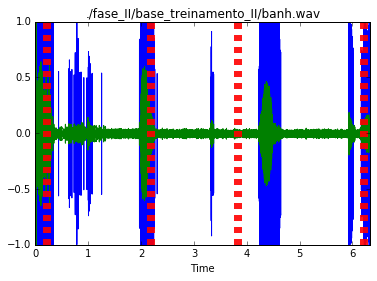

In [3]:
import preprocessing as trim

trim.trim('./fase_II/base_treinamento_II/banh.wav', '', True) #desenha o grafico

### 2.2 Análise preliminar de classificadores

Em um primeiro momento, é necessário criar a estrutura de pastas para que os algoritmos de mineração de dados atuem. É **assumido** que haja, no atual diretório, uma pasta chamada *fase\_1/base\_treinamento\_I* e uma pasta chamada *fase\_1/base_validacao\_I*. Dentro dessas pastas, há uma pasta para cada _captcha_ contendo um arquivo .wav, cujo nome são os quatro caracteres que compõem o _captcha_ na ordem em que aparecem.

Desta forma, a estrutura de pastas necessária para a classificação é montada. Os arquivos segmentados ficam nas pastas *output\_training* e *output\_test*. Dentro de cada pasta há um arquivo .wav para cada caractere identificado na segmentação. O nome de cada arquivo é *ordem\-caractere.wav*. Por exemplo, se o terceiro caractere de um dado _captcha_ for a letra "d", o nome do arquivo correspondente a ele será *3-d.wav*.

In [4]:
from model import train, test

In [5]:
from display_results import resultados_acuracia, resultados_caracteres

A seguir é necessário extrair atributos da base de dados.

A função `get_spectrum` extrai a intensidade média dentro de cada um dos [espectros de áudio](https://www.teachmeaudio.com/mixing/techniques/audio-spectrum/). Por exemplo, os espectros mais agudos poderiam ajudar um classificador a separar caracteres sibilantes (com sons de "S", como x e 7) de caracteres não sibilantes (como m e h).

Também extraímos, na função `extract_features`, com o auxílio da biblioteca *librosa*, o [MFCC](https://www.maxwell.vrac.puc-rio.br/23090/23090_4.PDF) (Mel-Frequency Cepstral Coefficients) das ondas sonoras. Para cada áudio, o MFCC retornado é uma matriz, onde cada linha possui um vetor numérico. O MFCC procura imitar as características que seres humanos percebem pelo ouvido. Para não lidar com um número absurdamente grande de atributos, usamos somente a mediana e o desvio padrão de cada vetor, que teve todos os valores tornados positivos. Isso foi feito porque os vetores do MFCC continham valores negativos e positivos (ondas), e assim a mediana tenderia a ser sempre próxima de zero.

Além disso, também com o auxílio da *librosa*, contamos quantas vezes o áudio corta o zero no eixo y. Também extraímos a mediana e o desvio padrão para os atributos *spectral_rolloff* e *spectral_centroid*.

O treinamento é feito sobre toda a base de treino, e os dados são normalizados de forma a terem média 0 e desvio 1. Isso é importante principalmente para algoritmos baseados em distância, de forma que atributos com valores maiores não dominem a classificação em detrimento de outros cujos valores tendem a ser mais próximos de zero.

In [6]:
X_train, y_train, std_scale = train()

Feito o treinamento, realizamos testes com dois classificadores, a partir do mesmo conjunto de atributos e sobre a mesma base de validação. Além dos _captchas_, procuramos analisar seu desempenho de forma individual, ou seja, caractere por caractere. Dessa forma, conseguiríamos identificar pontos fortes e fracos.

In [7]:
accuracy_captcha, accuracy_character, wrong, correct, elements = test(X_train, y_train, std_scale)

A partir de uma análise preliminar, foi percebido que o algoritmo SVM apresentava, no geral, bons índices de classificação. Contudo, sua taxa de erro era superior à de acerto para os caracteres 'd' e 'm'. Contudo, o algoritmo 1NN apresentava resultados superiores para este caractere. 

## 3. Metodologia

Para cada caso, é calculada a acurácia na detecção de cada caracter. Também é calculada a acurácia geral na detecção de caracteres. Por fim, é calculada a acurácia na detecção de _captchas_.

Os algoritmos usados, conforme já mencionado, são 1NN e SVM.

- 1NN:

    Uma variante do K-Nearest Neighbour (KNN) quando K=1. Em resumo, ele recebe um elemento de teste e calcula sua distância para os demais elementos na base de dados. O elemento de teste recebe a classe do elemento mais próximo. Podem ser usadas diferentes métricas de distância. As mais comuns são as distâncias euclidianas, Manhattan e Mahalanobis. No presente caso, foi usada a distância euclidiana.


- SVM:

    Sigla para _Support Vector Machine_. A partir de uma base de dados com elementos rotulados, o algoritmo constrói um modelo de pontos em um espaço de forma que cada classe esteja no espaço mais amplo possível. Então, ele traça retas, e os elementos são classificados conforme o local em que são colocados.

A análise exploratória mostrou que o algoritmo SVM apresentava um bom desempenho geral, mas nos casos específicos das letras 'd' e 'm', sua taxa de acerto era inferior à taxa de erro. O 1NN, por outro lado, apresentava resultados melhores. 

Foi usada, portanto, a seguinte heurística: o resultado escolhido é aquele indicado pelo SVM. Porém, caso tal resultado seja os caracteres 'd' ou 'm', opta-se pela resposta de 1NN. Como em somente 10% dos casos o SVM reportava 'd' como resposta corretamente, tal abordagem resultaria em um recall muito baixo da letra 'd'. Então, também foi decidido que sempre que 1NN reportasse o caractere 'd' ou o caractere 'm', sua resposta seria a escolhida.

## 4. Resultados

In [8]:
display(resultados_caracteres("Resultados finais", correct, wrong, elements))

RESULTADOS Resultados finais


|Caractere| Acerto        | Erro          |
|:--------|---------------:|:---------------|
|6 |49/70 (70.00%)|21/70 (30.00%)|
|7 |54/63 (85.71%)|9/63 (14.29%)|
|a |46/64 (71.88%)|18/64 (28.12%)|
|b |29/52 (55.77%)|23/52 (44.23%)|
|c |32/66 (48.48%)|34/66 (51.52%)|
|d |16/54 (29.63%)|38/54 (70.37%)|
|h |49/55 (89.09%)|6/55 (10.91%)|
|m |28/56 (50.00%)|28/56 (50.00%)|
|n |20/45 (44.44%)|25/45 (55.56%)|
|x |47/67 (70.15%)|20/67 (29.85%)|

**Resultados**

|Caractere| Acerto        | Erro          |
    |:--------|---------------:|:---------------|
    |6       |41/65 (63.08%) |24/65 (36.92%) |
    |7       |58/61 (95.08%) |03/61 (04.92%) |
    |a       |53/61 (86.89%) |08/61 (13.11%) |
    |b       |35/58 (60.34%) |23/58 (39.66%) |
    |c       |44/67 (65.67%) |23/67 (34.33%) |
    |d       |18/47 (38.30%) |29/47 (61.70%) |
    |h       |61/68 (89.71%) |07/68 (10.29%) |
    |m       |38/62 (61.29%) |24/62 (38.71%) |
    |n       |30/47 (63.83%) |17/47 (36.17%) |
    |x       |33/44 (75.00%) |11/44 (25.00%) |

A taxa de acerto superou a taxa de erro para todas as letras, exceto pela letra 'd'. Destaca-se a acurácia para o caractere '7', de 95%.

In [9]:
display(resultados_acuracia("", [("Acuracia (captcha)", "{0:.2f}".format(accuracy_captcha)), ("Acuracia (caracteres)", "{0:.2f}".format(accuracy_character)) ]))

RESULTADOS 


| Métrica                    | Taxa  |
|:-:|:-:|
|Acuracia (captcha)      | 18.12%|
|Acuracia (caracteres)      | 62.50%|

**Resultados**

|Métrica| Taxa        |
    |---------------:|:---------------|
    |Acuracia (captcha) |  27.21%|
    |Acuracia (caracteres) | 70.86%|

A acurácia obtida na detecção de _captchas_ está condizente com a acurácia individual de detecção de caracteres. A afirmação vem da suposição de que um classificador que obtenha 71% de acurácia para os caracteres tende, ao classificar um _captcha_ com quatro caracteres, obteria: 

$$0.71 \cdot 0.71 \cdot 0.71 \cdot 0.71 = 0.71^4 = 25.4\%$$

Nossos testes chegaram a 27.21% de acerto, próximo da expectativa teórica.

## 5. Comentários finais

- Dificuldades encontradas

    A segmentação não foi um processo trivial. Separar o áudio em faixas de tempo pré-determinadas era uma estratégia perigosa, e por isso foi necessário elaborar uma estratégia mais refinada.
    
    O tempo de execução dos diversos passos descritos acima, que somados demoram quase 15 minutos em uma máquina com um processador Core2Duo, ou 10 minutos em um Core i-7, também se mostrou uma dificuldade prática na hora de avaliar os algoritmos.
    


- Ideias que não foram exploradas e a razão

    Explorar mais atributos, por meio de outras funções da librosa (como spectral_centroid, spectral_contrast ou rmse). Porém, tais inclusões devem ser feitas sem que o tempo de 15 minutos seja rompido.